# Create T<sub>air</sub> for snow free period

The T<sub>air</sub> is filled with T<sub>air</sub> observations from Tomst data

In [1]:
import pandas as pd
from dotenv import load_dotenv; load_dotenv()
from datetime import datetime, timedelta
import os

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib as mpl
import xarray as xr

from utils import load_Ran_ec_data, load_Ran_biomet_data

from scipy.optimize import curve_fit
import scipy.stats as stats
from scipy.special import gamma

from sklearn.metrics import r2_score

import statsmodels.api as sm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import pymc as pm
import arviz as az

%matplotlib widget
%load_ext autoreload
%autoreload 2

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Preliminary data engineering

In [2]:
SOILCLASSIFICATION_DATA = os.getenv('SOILCLASSIFICATION_DATA')
ONEDRIVE_FOLDER = os.getenv('ONEDRIVE_FOLDER')

In [3]:
data = xr.open_dataset(f'{ONEDRIVE_FOLDER}/ec_biomet_wtd_2022_footprints_nan_all_times.nc')

In [4]:
data

<xarray.Dataset>
Dimensions:                     (time: 19344, soil_class: 10)
Coordinates:
  * time                        (time) datetime64[ns] 2021-11-24 ... 2022-12-...
  * soil_class                  (soil_class) <U16 'Fallen tree' ... 'Instrume...
Data variables: (12/103)
    H                           (time) float64 ...
    H_qf                        (time) float64 ...
    H_final                     (time) float64 ...
    rand_err_H                  (time) float64 ...
    LE                          (time) float64 ...
    LE_qf                       (time) float64 ...
    ...                          ...
    T_air_tomst_plot_3          (time) float64 ...
    soil_moisture_tomst_plot_3  (time) float64 ...
    T_soil_tomst_plot_4         (time) float64 ...
    T_surface_tomst_plot_4      (time) float64 ...
    T_air_tomst_plot_4          (time) float64 ...
    soil_moisture_tomst_plot_4  (time) float64 ...

## Define only the snow free period

In [5]:
snow_cover_end = datetime(2022,5,1)
snow_cover_start = datetime(2022,11,16)

## Set section from May (17.5. 10:30 - 20.5. 06:30) to np.nan 

value of T_air does not change in this section

In [6]:
data.TA_1_1_1[((data.time >= pd.to_datetime(datetime(2022,5,17,10,30))) & (data.time <= pd.to_datetime(datetime(2022,5,20,6,30))))] = np.nan

# Correlation

In [7]:
variables = ['TA_1_1_1','T_soil_ac','T_soil_tomst_plot_2','T_soil_tomst_plot_3','T_soil_tomst_plot_4','T_surface_tomst_plot_2','T_surface_tomst_plot_3','T_surface_tomst_plot_4','T_air_tomst_plot_2','T_air_tomst_plot_3','T_air_tomst_plot_4']

In [8]:
data_env = data[variables].to_dataframe()

In [9]:
data_env = data_env.rename(columns={'TA_1_1_1':'T_air'})

In [10]:
data_env = data_env.loc[snow_cover_end:snow_cover_start, :]

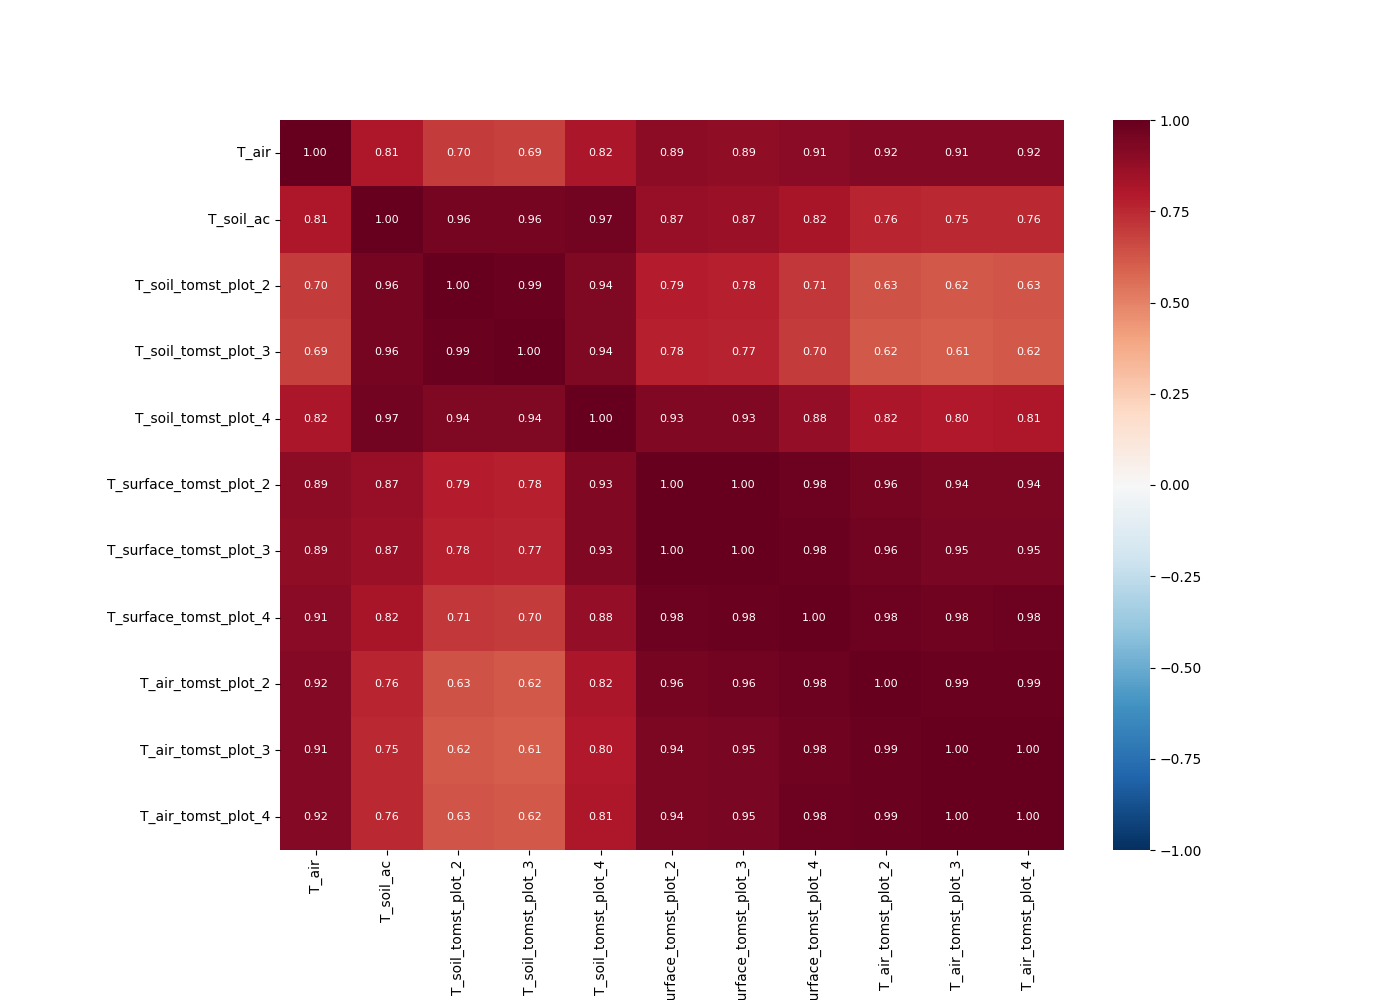

In [11]:
fig, ax = plt.subplots(figsize=(14,10))
fig.subplots_adjust(left=0.2, bottom=0.15)
hmp = sns.heatmap(data_env.corr(method='spearman'), cmap="RdBu_r", annot=True, fmt='.2f', ax=ax, annot_kws={'size': 8}, vmin=-1, vmax=1)
hmp.tick_params(axis='both', labelsize=10)

## Choose T<sub>air</sub> from Tomst plot 2

Text(0, 0.5, 'T$_{air}$')

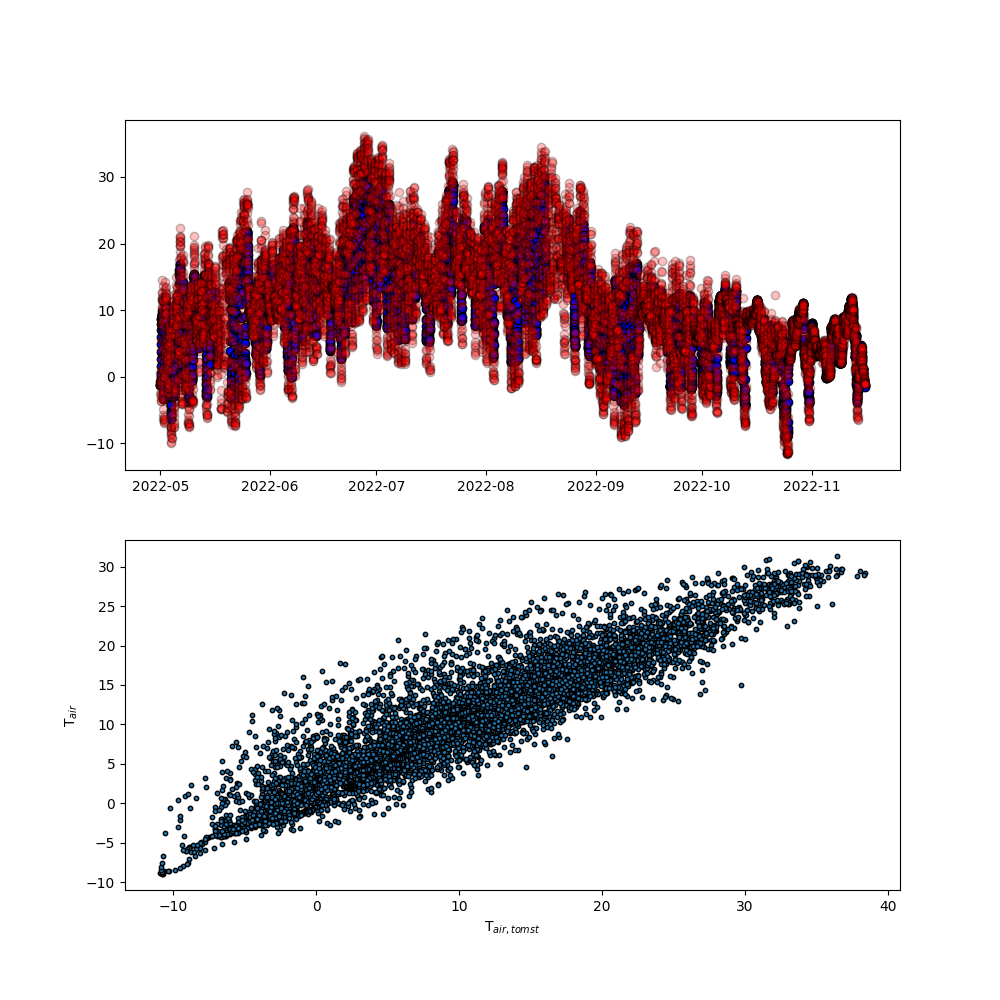

In [12]:
fig, axs = plt.subplots(figsize=(10,10), ncols=1, nrows=2)
axs= axs.flatten()
axs[0].plot(data_env.index, data_env['T_air'] ,'ko', markerfacecolor='b')
axs[0].plot(data_env.index, data_env['T_air_tomst_plot_4'], 'ko', markerfacecolor='r', alpha=0.25)
axs[1].scatter(data_env['T_air_tomst_plot_2'], data_env['T_air'], s=10, edgecolors='k')
axs[1].set_xlabel('T$_{air, tomst}$')
axs[1].set_ylabel('T$_{air}$')

## Fit a linear model to predict T<sub>air</sub> from T<sub>air,tomst2</sub>

In [13]:
Y = data_env['T_air']
X = sm.add_constant(data_env['T_air_tomst_plot_2'])

X = X.loc[~np.isnan(Y), :]
Y = Y[~np.isnan(Y)]

mod = sm.OLS(Y,X)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  T_air   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                 5.163e+04
Date:                Mon, 26 Feb 2024   Prob (F-statistic):               0.00
Time:                        16:19:29   Log-Likelihood:                -22202.
No. Observations:                9129   AIC:                         4.441e+04
Df Residuals:                    9127   BIC:                         4.442e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.8535      0.045     62.897      0.000       2.765       2.942
T_air_tomst_plot_2     0.7490      0.003    227.223      0.000       0.743       0.755
==============================================================================
Omnibus:                     1869.215   Durbin-Watson:                   0.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4823.986
Skew:                           1.114   Prob(JB):                         0.00
Kurtosis:                       5.779   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Predict the missing T<sub>air</sub> values

In [14]:
X_predcit = data_env.loc[np.isnan(data_env['T_air']), 'T_air_tomst_plot_2'].to_numpy()
X_predcit = sm.add_constant(X_predcit)

T_air_missing_nans = res.predict(X_predcit)

# Put to seperate array

In [15]:
T_air = data_env['T_air'].copy()

T_air[np.isnan(T_air)] = T_air_missing_nans

# Plot results

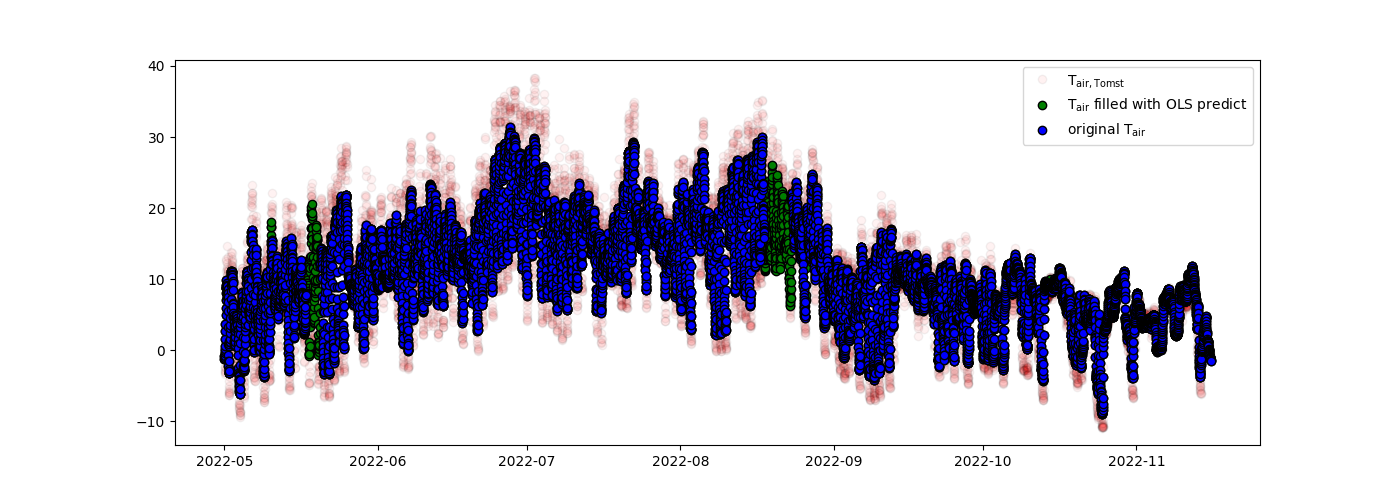

In [16]:
fig, ax = plt.subplots(figsize=(14,5))

ax.plot(data_env.index, data_env['T_air_tomst_plot_2'], 'ko', markerfacecolor='r', alpha=0.05, label='T$_{\mathrm{air, Tomst}}$')
ax.plot(data_env.index, T_air, 'ko', markerfacecolor='g', label='T$_{\mathrm{air}}$ filled with OLS predict')
ax.plot(data_env.index, data_env['T_air'] ,'ko', markerfacecolor='b', label='original T$_{\mathrm{air}}$')
ax.legend(loc='best')



# Save T<sub>air</sub> as a seperate csv

In [17]:
T_air.to_csv('T_air_snow_free_period_gapfilled.csv')